Header Files

In [13]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

Data Reading and combining

In [2]:
B05 = pd.read_csv('../Battery_data/B0005_discharge_.csv')
B06 = pd.read_csv('../Battery_data/B0006_discharge_.csv')
B07 = pd.read_csv('../Battery_data/B0007_discharge.csv')
B18 = pd.read_csv('../Battery_data/B0018_discharge_.csv')

# print the first few rows
print(B05.head())
B05.shape
df = B05  # assigning B05 as the data we are concerned about



   cycle  ambient_temperature  capacity  voltage_measured  current_measured  \
0      1                   24  1.856487          4.191492         -0.004902   
1      1                   24  1.856487          4.190749         -0.001478   
2      1                   24  1.856487          3.974871         -2.012528   
3      1                   24  1.856487          3.951717         -2.013979   
4      1                   24  1.856487          3.934352         -2.011144   

   temperature_measured  current_load  voltage_load    time  RUL  
0             24.330034       -0.0006         0.000   0.000  167  
1             24.325993       -0.0006         4.206  16.781  167  
2             24.389085       -1.9982         3.062  35.703  167  
3             24.544752       -1.9982         3.030  53.781  167  
4             24.731385       -1.9982         3.011  71.922  167  


Parameter Evaluation

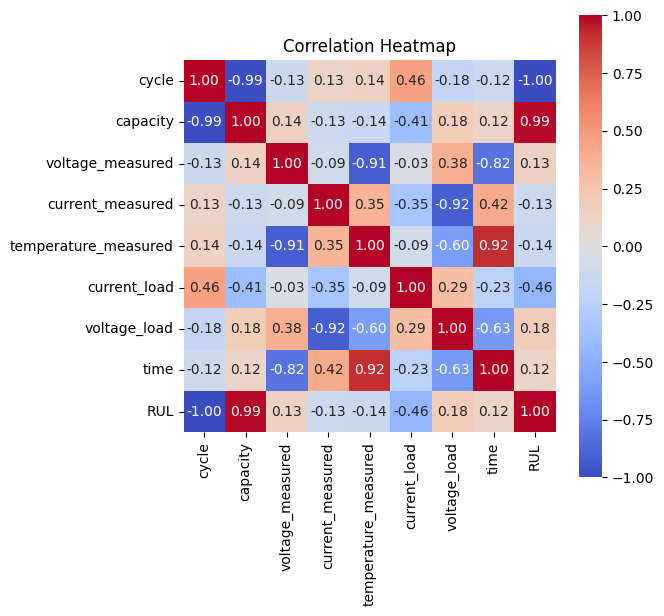

capacity                1.000000
RUL                     0.986857
voltage_load            0.181684
voltage_measured        0.135859
time                    0.119542
current_measured       -0.132162
temperature_measured   -0.143717
current_load           -0.407819
cycle                  -0.986857
ambient_temperature          NaN
Name: capacity, dtype: float64


In [18]:
corr = df[['cycle','capacity','voltage_measured','current_measured','temperature_measured','current_load','voltage_load','time','RUL']].corr()
plt.figure(figsize=(6, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()
print(df.corr()['capacity'].sort_values(ascending=False))
